## Imports

In [6]:

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, when
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.feature import Tokenizer, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector, StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.feature import IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import PipelineModel
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import pandas as pd
import warnings
import praw
import os

warnings.simplefilter('ignore')

## Spark Session

In [7]:
# Initialize a Spark session
spark = SparkSession.builder\
            .master("local[16]")\
            .appName("LR_Twitter")\
            .config("spark.driver.memory", "6g")\
            .config("spark.executor.memory", "6g")\
            .config("spark.driver.maxResultSize", "3g")\
            .getOrCreate()
spark.sparkContext.setLogLevel("OFF")


## Cleaning Dataset

In [8]:
def clean_text(text):
    negations_dic = {
        "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
        "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "won't": "will not",
        "wouldn't": "would not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
        "can't": "cannot", "couldn't": "could not", "shouldn't": "should not", "mightn't": "might not",
        "mustn't": "must not"
    }
    
    combined_pat = r'|'.join((r'@[A-Za-z0-9_]+', r'https?://[^ ]+', r'www.[^ ]+'))
    www_pat = r'www.[^ ]+'
    neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
    tok = WordPunctTokenizer()

    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x in tok.tokenize(letters_only) if len(x) > 1]
    return " ".join(words).strip()


## Cleaning Dataset Process

In [9]:


schema = StructType([
    StructField("target", IntegerType(), False),
    StructField("id", IntegerType(), False),
    StructField("date", StringType(), True),
    StructField("query", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)
])

# Load data with the defined schema
df = spark.read.csv("training.1600000.processed.noemoticon.csv", header=None, schema=schema, encoding='ISO-8859-1')

print("========================Before cleaning========================")

df.show()

# Apply the cleaning function to the "text" column
clean_text_udf = udf(clean_text, StringType())
df = df.withColumn("text",clean_text_udf(df["text"]))

# Map sentiment (0 to 0 and 4 to 1)
df = df.withColumn("target", when(df["target"] == 0, 0).otherwise(1))

# Select the relevant columns (index, sentiment, and cleaned text)
df = df.select("text", "target")

print("========================After cleaning========================")

df.show()

# Convert the Spark DataFrame to a pandas DataFrame
df_pandas = df.toPandas()

# Save the pandas DataFrame to a CSV file
df_pandas.to_csv("clean_tweet.csv", index=True, encoding='utf-8')

st = datetime.utcnow()
print('Cleaning time:', datetime.utcnow() - st)

========================Before cleaning========================
+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|   query|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@

/var/folders/wj/77hbr_q13jvfxz5tlm0vsy840000gn/T/ipykernel_12209/3590339814.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


+--------------------+------+
|                text|target|
+--------------------+------+
|awww that bummer ...|     0|
|is upset that he ...|     0|
|dived many times ...|     0|
|my whole body fee...|     0|
|no it not behavin...|     0|
|  not the whole crew|     0|
|            need hug|     0|
|hey long time no ...|     0|
|nope they did not...|     0|
|        que me muera|     0|
|spring break in p...|     0|
|just re pierced m...|     0|
|could not bear to...|     0|
|it it counts idk ...|     0|
|would ve been the...|     0|
|wish got to watch...|     0|
|hollis death scen...|     0|
| about to file taxes|     0|
|ahh ive always wa...|     0|
|oh dear were you ...|     0|
+--------------------+------+
only showing top 20 rows



/var/folders/wj/77hbr_q13jvfxz5tlm0vsy840000gn/T/ipykernel_12209/3590339814.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
/var/folders/wj/77hbr_q13jvfxz5tlm0vsy840000gn/T/ipykernel_12209/3590339814.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
/var/folders/wj/77hbr_q13jvfxz5tlm0vsy840000gn/T/ipykernel_12209/3590339814.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
/var/folders/wj/77hbr_q13jvfxz5tlm0vsy840000gn/T/ipykernel_12209/3590339814.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
/var/folders/wj/77hbr_q13jvfxz5tlm0vsy84

Cleaning time: 0:00:00.000027


## Load Cleaned CSV

In [10]:

# Load your dataset
path = "clean_tweet.csv"
schema = StructType([
    StructField("_", StringType(), True),  # Skip the first column
    StructField("text", StringType(), True),
    StructField("target", IntegerType(), True)
])
df = spark.read.csv(path, inferSchema=True, header=False, schema=schema).na.drop()
num_columns = len(df.columns)

print(f"Number of rows in the DataFrame: {df.count()}")

df = df.select("text", "target")

df.show()
df.printSchema()

Number of rows in the DataFrame: 1596041
+--------------------+------+
|                text|target|
+--------------------+------+
|awww that bummer ...|     0|
|is upset that he ...|     0|
|dived many times ...|     0|
|my whole body fee...|     0|
|no it not behavin...|     0|
|  not the whole crew|     0|
|            need hug|     0|
|hey long time no ...|     0|
|nope they did not...|     0|
|        que me muera|     0|
|spring break in p...|     0|
|just re pierced m...|     0|
|could not bear to...|     0|
|it it counts idk ...|     0|
|would ve been the...|     0|
|wish got to watch...|     0|
|hollis death scen...|     0|
| about to file taxes|     0|
|ahh ive always wa...|     0|
|oh dear were you ...|     0|
+--------------------+------+
only showing top 20 rows

root
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)



## WordCloud

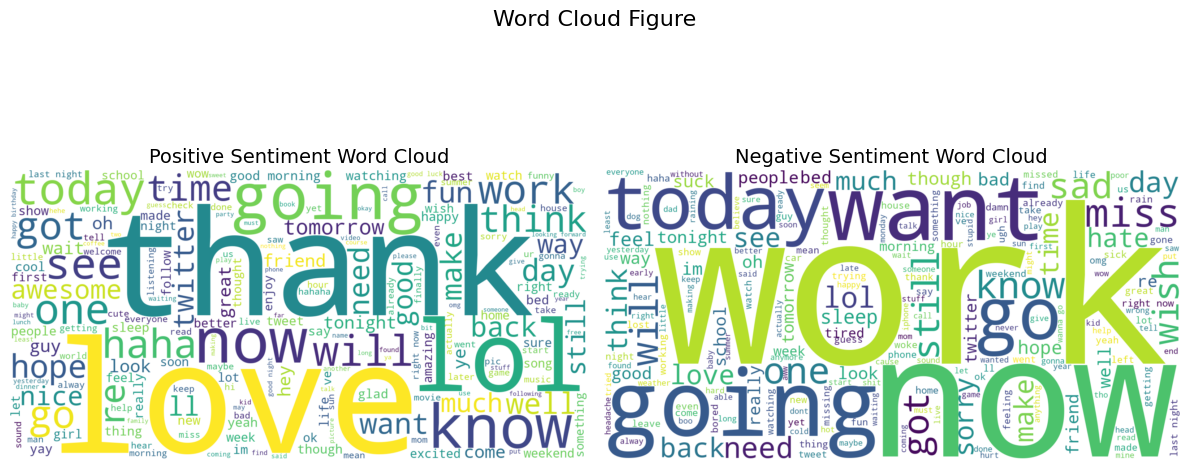

In [11]:
# Separate positive and negative sentiments
positive_text = " ".join(df[df['target'] == 1].rdd.map(lambda row: row['text']).collect())
negative_text = " ".join(df[df['target'] == 0].rdd.map(lambda row: row['text']).collect())

# Create a word cloud for positive sentiments with larger dimensions
positive_wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(positive_text)

# Create a word cloud for negative sentiments with larger dimensions
negative_wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(negative_text)

# Create a larger figure
plt.figure(figsize=(12, 6))

# Add a title to the figure
plt.suptitle("Word Cloud Figure", fontsize=16)

# Create subplots with adjusted size
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud', fontsize=14)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud', fontsize=14)
plt.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the word clouds
plt.show()

## Training

In [12]:
# Split dataset into a training set and a test set
(train_set, test_set) = df.randomSplit([0.80, 0.20], seed=2000)

# Define a function to buildthe pipeline with trigrams
def build_trigrams(inputCol=["text", "target"], n=3):
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]

    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14, inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]

    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    stopword_remover = [StopWordsRemover(inputCol="words", outputCol="filtered")]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]

    label_stringIdx = [StringIndexer(inputCol="target", outputCol="label")]

    selector = [ChiSqSelector(numTopFeatures=2**14, featuresCol='rawFeatures', outputCol="features")]

    lr = [LogisticRegression(regParam=0.005)]

    return Pipeline(stages=tokenizer + stopword_remover + ngrams + cv + idf + assembler + label_stringIdx + selector + lr)


st = datetime.utcnow()

pipelineFit = build_trigrams().fit(train_set)
print('Training time:', datetime.utcnow() - st)

# Get the current directory
current_directory = os.getcwd()

# Construct the model path in the current directory
model_path = os.path.join(current_directory, "lr_mode") # Save the trained model
pipelineFit.write().overwrite().save(model_path)

#Get Metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
predictions = pipelineFit.transform(test_set)
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Get the ROC AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
roc_auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

# Print the results
print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Training time: 0:01:27.125474


ROC AUC: 0.8864670105037871
Accuracy: 0.8119824951592671
Precision: 0.8129291389735127
Recall: 0.8119824951592671


## Distribution of sentiments in labeled dataset

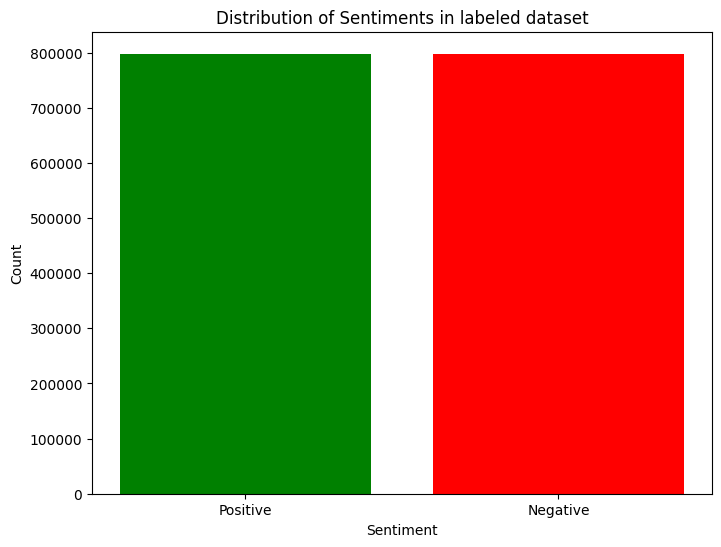

In [13]:
# Count the number of positive and negative sentiments in the labeled dataset
positive_count = df[df['target'] == 1].count()
negative_count = df[df['target'] == 0].count()

# Create a bar chart to show the distribution
sentiments = ['Positive', 'Negative']
counts = [positive_count, negative_count]

plt.figure(figsize=(8, 6))
plt.bar(sentiments, counts, color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in labeled dataset')
plt.show()
plt.close()


## Real time prediction on Reddit

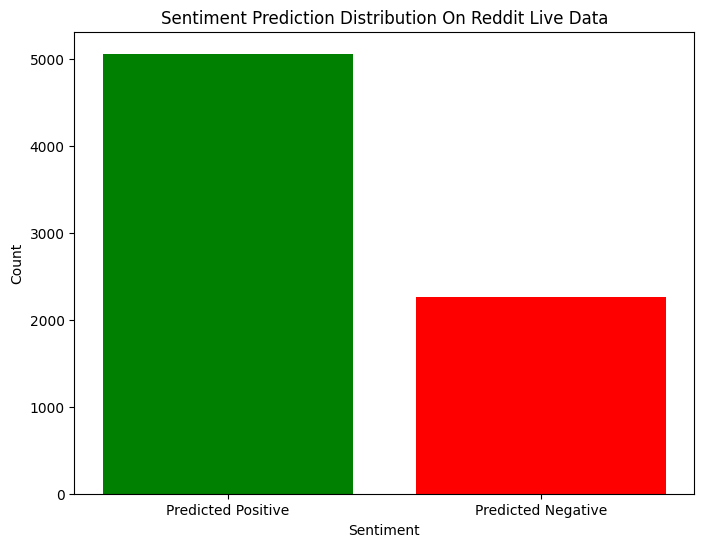

Sentiment analysis completed for Reddit data


In [17]:

# Reddit API setup
reddit = praw.Reddit(
    client_id='mJMczWy81dMME1r9v9OBiQ',
    client_secret='tdsaBJ8OiNORXPvbw1jwFkNCaQY3GQ',
    user_agent='redit api2',
    username='Public-Quantity3513',
    password='siCsur-2qujcy-tehmim'
)

subreddit_name = 'DataScience'


# Load the sentiment analysis pipeline model
model_path = "your_model_name"  # Replace with the actual path
pipeline_model = PipelineModel.load(model_path)

clean_text_udf = udf(clean_text, StringType())

def process_post(post):
    post_comment_bodies = []
    for comment in post.comments.list():
        if isinstance(comment, praw.models.Comment) and not comment.body == '[deleted]':
            cleaned_text = clean_text(comment.body)
            post_comment_bodies.append(cleaned_text)
    return post_comment_bodies

def predict_sentiment(comment_bodies):
    schema = StructType([StructField("text", StringType(), True)])
    df = spark.createDataFrame([(body,) for body in comment_bodies], schema=schema)
    predictions = pipeline_model.transform(df)
    
    # Collect predicted labels
    predicted_labels = predictions.select('prediction').collect()
    
    # Plot the distribution of predicted sentiments
    predicted_positive_count = sum(1 for label in predicted_labels if label[0] == 1)
    predicted_negative_count = sum(1 for label in predicted_labels if label[0] == 0)

    predicted_sentiments = ['Predicted Positive', 'Predicted Negative']
    predicted_counts = [predicted_positive_count, predicted_negative_count]

    plt.figure(figsize=(8, 6))
    plt.bar(predicted_sentiments, predicted_counts, color=['green', 'red'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiment Prediction Distribution On Reddit Live Data')
    plt.show()
    plt.close()


try:
    hot_posts = reddit.subreddit(subreddit_name).hot(limit=500)
    all_comment_bodies = []

    for post in hot_posts:
        comment_bodies = process_post(post)
        all_comment_bodies.extend(comment_bodies)

    # Predict sentiment for all comments
    predict_sentiment(all_comment_bodies)

    print("Sentiment analysis completed for Reddit data")

except praw.exceptions.APIException as e:
    print(f"Reddit API Exception: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

finally:
    # Stop Spark session
    spark.stop()
